# 0. Importing Packages

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Load Reference Data

In [3]:
# Define the reference colors and values
reference_df = pd.read_csv('/content/drive/MyDrive/Projects/Research Projects/CO2_Sensor/Datasets/ph-data.csv')

# Create the dictionary
reference = {(r['red'], r['green'], r['blue']): r['label'] for _, r in reference_df.iterrows()}

# Prepare data
X = np.array(list(reference.keys()))
y = np.array(list(reference.values()))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 1.1. Visualize Data: 14 Samples

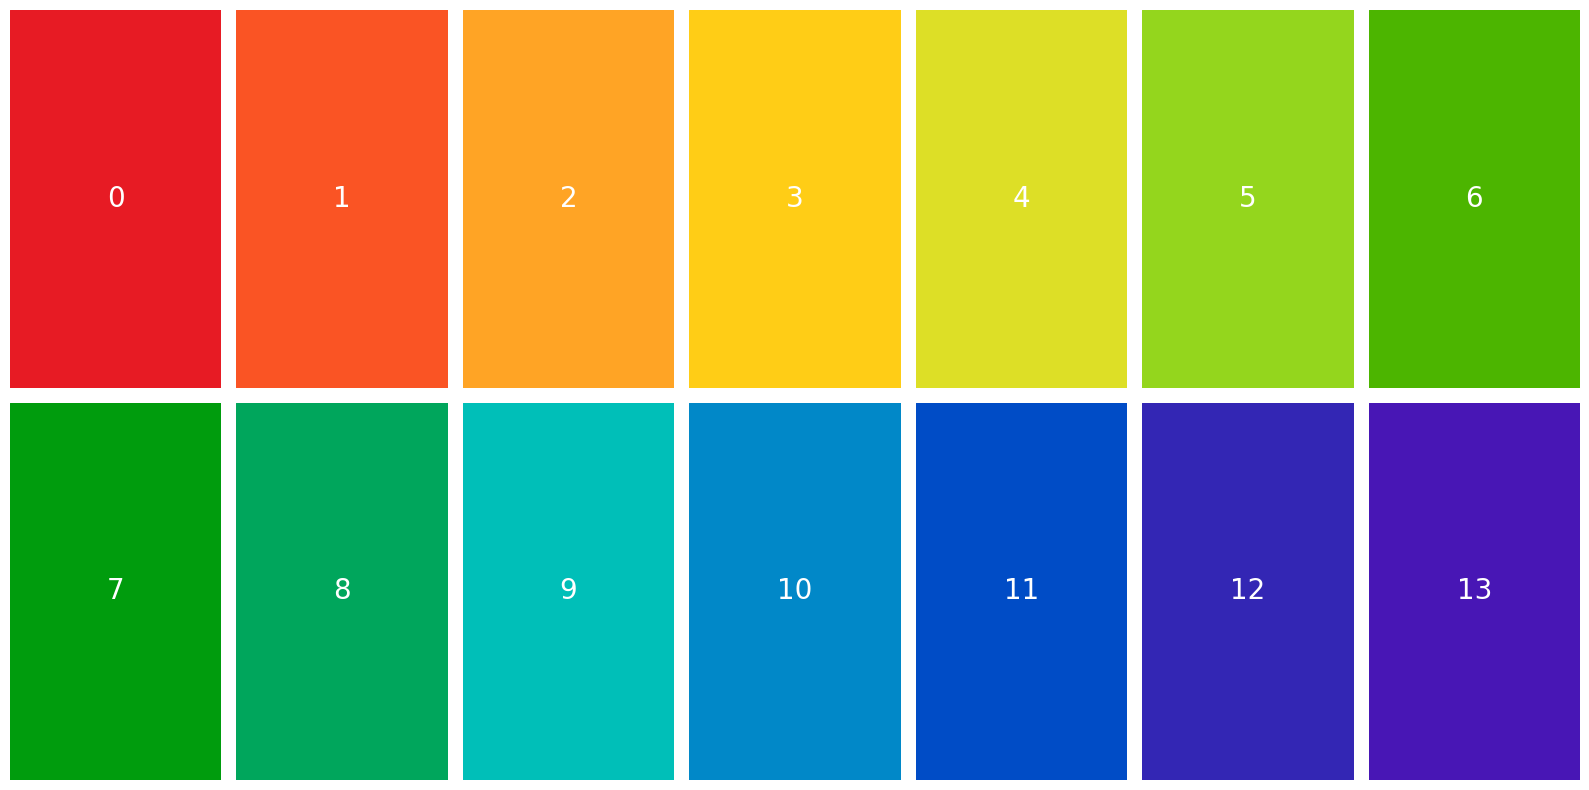

In [4]:
# Select the first 14 entries
reference_14 = dict(list(reference.items())[:14])

# Normalize RGB values to the range [0, 1]
normalized_reference_14 = {tuple(np.array(k) / 255): v for k, v in reference_14.items()}

# Create color tiles plot
n_colors = len(reference_14)
cols = 7
rows = n_colors // cols + (1 if n_colors % cols else 0)

fig, ax = plt.subplots(rows, cols, figsize=(16, 8))

for i, (color, ph) in enumerate(normalized_reference_14.items()):
    row, col = divmod(i, cols)
    ax[row, col].add_patch(plt.Rectangle((0, 0), 1, 1, color=color))
    ax[row, col].text(0.5, 0.5, str(ph), fontsize=20, ha='center', va='center', color='w')
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()

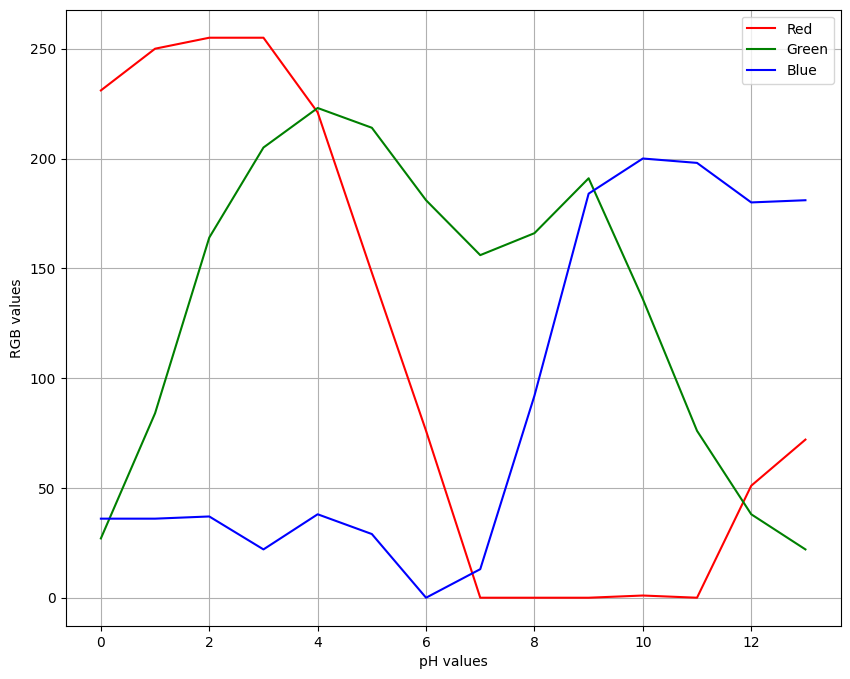

In [16]:
# Unpack the RGB and pH values
rgb_values, ph_values = zip(*reference_14.items())
red_values, green_values, blue_values = zip(*rgb_values)

# Create the plot
plt.figure(figsize=(10, 8))

plt.plot(ph_values, red_values, color='red', label='Red')
plt.plot(ph_values, green_values, color='green', label='Green')
plt.plot(ph_values, blue_values, color='blue', label='Blue')

plt.xlabel('pH values')
plt.ylabel('RGB values')
#plt.title('RGB values vs pH values')
plt.legend()
plt.grid()
plt.show()

## 1.2. Visualize Data: Total Sample

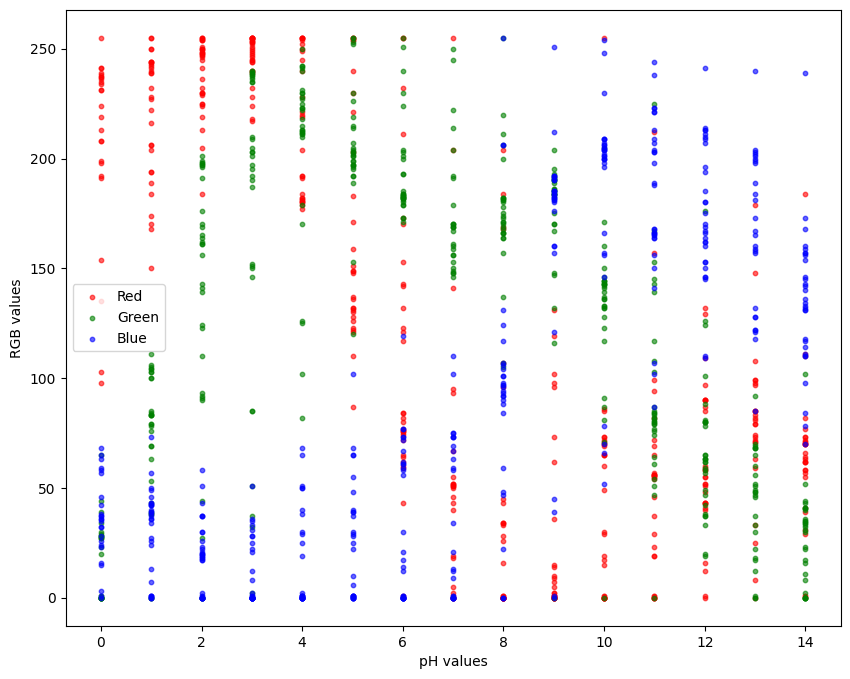

In [17]:
# Unpack the RGB and pH values
rgb_values, ph_values = zip(*reference.items())
red_values, green_values, blue_values = zip(*rgb_values)

# Create the plot
plt.figure(figsize=(10, 8))

plt.scatter(ph_values, red_values, color='red', label='Red', s=10, alpha=0.6)
plt.scatter(ph_values, green_values, color='green', label='Green', s=10, alpha=0.6)
plt.scatter(ph_values, blue_values, color='blue', label='Blue', s=10, alpha=0.6)

plt.xlabel('pH values')
plt.ylabel('RGB values')
#plt.title('RGB values vs pH values')
plt.legend()
plt.show()

In [7]:
import plotly.graph_objects as go

# Unpack the RGB and pH values
rgb_values, ph_values = zip(*reference.items())
red_values, green_values, blue_values = zip(*rgb_values)

# Create the plot
fig = go.Figure(data=[go.Scatter3d(
    x=red_values,
    y=green_values,
    z=blue_values,
    mode='markers',
    marker=dict(
        size=5,
        color=ph_values,                # set color to an array/list of desired values
        colorscale='Viridis',           # choose a colorscale
        opacity=0.8,
        colorbar=dict(title='pH value') # customize the colorbar
    )
)])

# tight layout
fig.update_layout(scene = dict(
                    xaxis_title='Red Values',
                    yaxis_title='Green Values',
                    zaxis_title='Blue Values'),
                    width=700,
                    margin=dict(r=20, l=10, b=10, t=10))
fig.show()

# 2. Load Sample Image

In [8]:
IMAGE_PATH = '/content/drive/MyDrive/Projects/Research Projects/CO2_Sensor/Datasets/Images/Colors/'
IMAGE_FILE = '3_color_#4169E1.png'

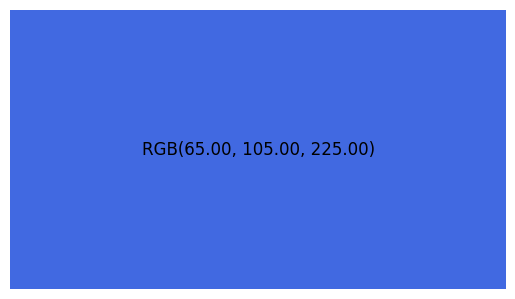

In [9]:
# Load image file
image = cv2.imread(os.path.join(IMAGE_PATH, IMAGE_FILE))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Calculate the average RGB value using numpy.mean()
rgb_color_per_row = np.mean(image, axis=0)
rgb_color = np.mean(rgb_color_per_row, axis=0)
prompt = f"RGB({rgb_color[0]:.2f}, {rgb_color[1]:.2f}, {rgb_color[2]:.2f})"

# Choose white color for text if rgb_color is dark, black if rgb_color is light
text_color = 'white' if np.mean(rgb_color) < 128 else 'black'

fig, ax = plt.subplots()

# Show image
ax.imshow(image)

# Put prompt text in the middle of the image
text_x = image.shape[1] / 2
text_y = image.shape[0] / 2

ax.text(text_x, text_y, prompt, fontsize=12, ha='center', va='center', color=text_color, bbox=dict(facecolor='none', edgecolor='none'))
ax.axis('off')

plt.show()

# 3. Estimate Values

## 3.1. Polynomial Fit

In [10]:
# Flatten RGB values into a single dimension
X_flat = X.mean(axis=1)

# Fit a polynomial of degree 3
coefficients = np.polyfit(X_flat, y, 3)

# Now we can use the coefficients to make predictions
rgb_value_flat = np.mean(rgb_color)

predicted_ph = np.polyval(coefficients, rgb_value_flat)

print(f"Predicted pH: {predicted_ph:.2f}")

Predicted pH: 5.90


## 3.2. Random Forest Model

In [11]:
from sklearn.ensemble import RandomForestRegressor

# Create and train the model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Evaluate the model on the test set
score = model_rf.score(X_test, y_test)
print(f"Model accuracy: {score*100:.2f}%")

# Now we can use the model to predict pH values
predicted_ph = model_rf.predict([rgb_color])

print(f"Predicted pH: {predicted_ph[0]:.2f}")

Model accuracy: 94.68%
Predicted pH: 12.03


## 3.3. Gradient Boosting Model

In [12]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the model
model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42, loss='squared_error')

# Fit the model to the training data
model_gb.fit(X_train, y_train)

# Check the accuracy of the model on the testing data
score = model_gb.score(X_test, y_test)
print(f"Model accuracy: {score*100:.2f}%")

# Predict pH level for a given RGB value
predicted_ph = model_gb.predict([rgb_color])

print(f"Predicted pH: {predicted_ph[0]:.2f}")

Model accuracy: 82.88%
Predicted pH: 11.33


## 3.4. Support Vector Machine

In [13]:
from sklearn.svm import SVR

# Initialize the model
model_svm = SVR(kernel='rbf', C=1.0, epsilon=0.2)

# Fit the model to the training data
model_svm.fit(X_train, y_train)

# Check the accuracy of the model on the testing data
score = model_svm.score(X_test, y_test)
print(f"Model accuracy: {score*100:.2f}%")

# Predict pH level for a given RGB value
predicted_ph = model_svm.predict([rgb_color])

print(f"Predicted pH: {predicted_ph[0]:.2f}")

Model accuracy: 93.49%
Predicted pH: 10.98


## 3.5. Neural Network

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Define the model
model_nn = Sequential()
model_nn.add(Dense(64, input_dim=3, activation='relu'))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(1, activation='linear'))

# Compile the model
model_nn.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])

# Fit the model to the training data
model_nn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=10, verbose=0)

# Evaluate the model
scores = model_nn.evaluate(X_test, y_test, verbose=0)
print(f"Model performance: MAE = {scores[1]:.2f}")

# Predict pH level for a given RGB value
predicted_ph = model_nn.predict(rgb_color.reshape(1, -1))

print(f"Predicted pH: {predicted_ph[0][0]:.2f}")

Model performance: MAE = 1.30
1/1 [==============================] - 0s 64ms/step
Predicted pH: 12.59


# 4. Results

1/1 [==============================] - 0s 18ms/step


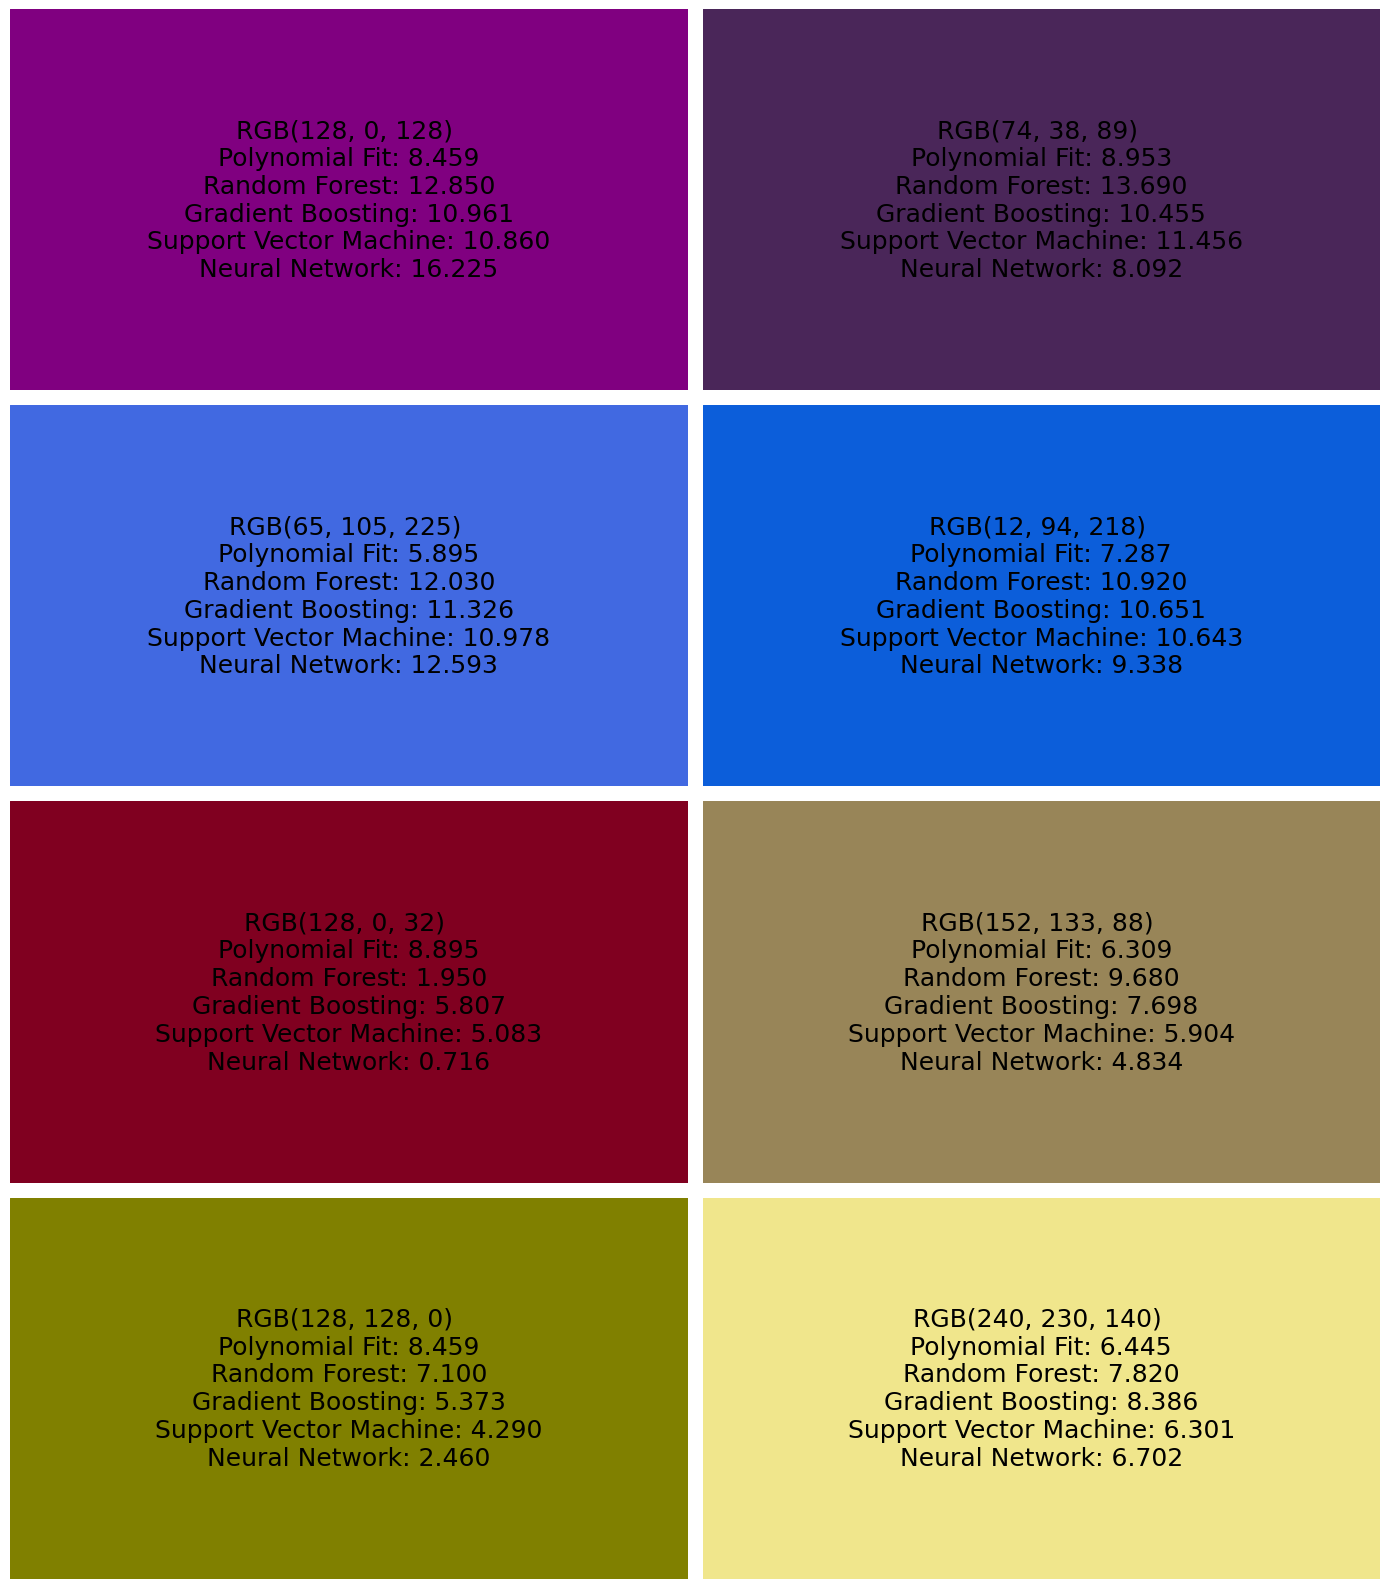

In [15]:
# Load images
FOLDER_PATH = '/content/drive/Shareddrives/CO2 sensor device/Min & Jamie/Datasets/Images/Colors/'
image_files = os.listdir(FOLDER_PATH)

# Define the number of columns for the plot
cols = 2

# Define the number of rows needed for the plot
rows = len(image_files) // cols
if len(image_files) % cols:
    rows += 1

# Initialize the plot
fig, ax = plt.subplots(rows, cols, figsize=(14, 16))

# Initialize the list to store average colors of test images
avg_colors = []

# Iterate over the images
for i, image_file in enumerate(image_files):
    # Load image file
    image = cv2.imread(os.path.join(FOLDER_PATH, image_file))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Calculate the average RGB value using numpy.mean()
    avg_color_per_row = np.mean(image, axis=0)
    avg_color = np.mean(avg_color_per_row, axis=0)
    avg_colors.append(avg_color)

    # Predict
    # Random Forest Model
    ph_rf = model_rf.predict([avg_color])

    # Polynomial Fit
    rgb_value_flat = np.mean(avg_color)
    ph_pf = np.polyval(coefficients, rgb_value_flat)

    # Gradient Boosting Model
    ph_gb = model_gb.predict([avg_color])

    # Support Vector Machine
    ph_svm = model_svm.predict([avg_color])

    # Neural Network
    ph_nn = model_nn.predict(avg_color.reshape(1, -1))

    # Compute current row and column
    row, col = divmod(i, cols)

    # Create color tile
    ax[row, col].add_patch(plt.Rectangle((0, 0), 1, 1, color=np.array(avg_color)/255))
    ax[row, col].axis('off')

    # Add text to the tile
    results = results = (
    f"RGB({avg_color[0]:.0f}, {avg_color[1]:.0f}, {avg_color[2]:.0f}) \n"
    f"Polynomial Fit: {ph_pf:.3f}\n"
    f"Random Forest: {ph_rf[0]:.3f}\n"
    f"Gradient Boosting: {ph_gb[0]:.3f}\n"
    f"Support Vector Machine: {ph_svm[0]:.3f}\n"
    f"Neural Network: {ph_nn[0][0]:.3f}"
    )
    ax[row, col].text(0.5, 0.5, results, fontsize=18, ha='center', va='center', color='k')

# For any leftover subplots, remove their axes
for j in range(i+1, rows*cols):
    row, col = divmod(j, cols)
    fig.delaxes(ax[row, col])

plt.tight_layout()
plt.show()